In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_dir = '/content/drive/My Drive/Deep Learning project/potato-disease/training/Images'

In [5]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

**Exploring the tensor dataset**

In [7]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=50

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [9]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [10]:
len(dataset)

68

In [11]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 1 1 1 1 0 0 1 0 0 1 0 2 1 0 1 1 1 2 1 1 1 1 0 0 0 1 0 0 1 1]


In [12]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch[0].numpy())
  

[[[176. 169. 176.]
  [172. 165. 172.]
  [169. 162. 169.]
  ...
  [169. 164. 171.]
  [170. 165. 172.]
  [172. 167. 174.]]

 [[173. 166. 173.]
  [172. 165. 172.]
  [171. 164. 171.]
  ...
  [167. 162. 169.]
  [167. 162. 169.]
  [167. 162. 169.]]

 [[168. 161. 168.]
  [169. 162. 169.]
  [171. 164. 171.]
  ...
  [171. 166. 173.]
  [169. 164. 171.]
  [168. 163. 170.]]

 ...

 [[114. 103. 107.]
  [116. 105. 109.]
  [115. 104. 108.]
  ...
  [128. 122. 126.]
  [130. 124. 128.]
  [128. 122. 126.]]

 [[115. 104. 108.]
  [114. 103. 107.]
  [110.  99. 103.]
  ...
  [135. 129. 133.]
  [135. 129. 133.]
  [131. 125. 129.]]

 [[110.  99. 103.]
  [107.  96. 100.]
  [102.  91.  95.]
  ...
  [135. 129. 133.]
  [134. 128. 132.]
  [130. 124. 128.]]]


Visualising the images

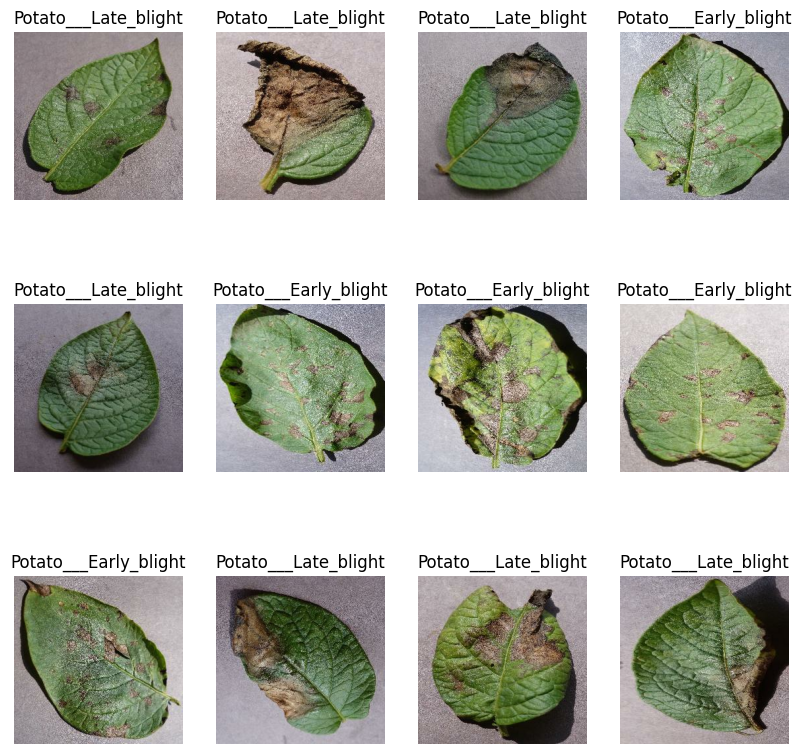

In [13]:
# First Image
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

Splitting the dataset

In [14]:
# 80% ==> training
# 20% ==> 10% validation, 10% test

In [15]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [16]:
train_ds = dataset.take(54)
len(train_ds)

54

In [17]:
test_ds = dataset.skip(54)
len(test_ds) 

14

In [18]:
val_size = 0.1
len(dataset)*val_size #so we need six samples for validation

6.800000000000001

In [19]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [20]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [21]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)
  train_size = int(train_split*ds_size)
  val_size = int(val_split*ds_size)
  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)
  return train_ds, val_ds, test_ds


In [22]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [23]:
len(train_ds)

54

In [24]:
len(val_ds)

6

In [25]:
len(test_ds)

8

caching and pre-fetching

In [26]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [27]:
resize_and_rescale = tf.keras.Sequential([
layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
layers.experimental.preprocessing.Rescaling(1.0/255)       
                     ])

Data Augmentation

In [28]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

**Model Building**

In [29]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

In [30]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [32]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [33]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose=1,
    validation_data = val_ds
)

Epoch 1/50
54/54 [==============================] - 384s 133ms/step - loss: 0.8973 - accuracy: 0.5104 - val_loss: 0.8087 - val_accuracy: 0.7083
Epoch 2/50
54/54 [==============================] - 3s 62ms/step - loss: 0.6311 - accuracy: 0.7309 - val_loss: 0.4835 - val_accuracy: 0.7812
Epoch 3/50
54/54 [==============================] - 3s 62ms/step - loss: 0.4471 - accuracy: 0.8079 - val_loss: 0.3249 - val_accuracy: 0.8438
Epoch 4/50
54/54 [==============================] - 3s 60ms/step - loss: 0.3076 - accuracy: 0.8825 - val_loss: 0.4994 - val_accuracy: 0.8021
Epoch 5/50
54/54 [==============================] - 3s 60ms/step - loss: 0.3214 - accuracy: 0.8640 - val_loss: 0.1927 - val_accuracy: 0.9375
Epoch 6/50
54/54 [==============================] - 3s 63ms/step - loss: 0.2455 - accuracy: 0.9016 - val_loss: 0.2091 - val_accuracy: 0.9010
Epoch 7/50
54/54 [==============================] - 3s 61ms/step - loss: 0.2155 - accuracy: 0.9190 - val_loss: 0.1426 - val_accuracy: 0.9479
Epoch 8/50

In [34]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 5s 29ms/step - loss: 0.1035 - accuracy: 0.9648


In [35]:
scores

[0.10352779179811478, 0.96484375]

In [36]:
history

In [37]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [38]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [40]:
history.history['accuracy']

[0.5104166865348816,
 0.7309027910232544,
 0.8078703880310059,
 0.8825231194496155,
 0.8640046119689941,
 0.9016203880310059,
 0.9189814925193787,
 0.9247685074806213,
 0.9195601940155029,
 0.9265046119689941,
 0.9409722089767456,
 0.9444444179534912,
 0.9467592835426331,
 0.9490740895271301,
 0.9571759104728699,
 0.9664351940155029,
 0.9675925970077515,
 0.9629629850387573,
 0.9589120149612427,
 0.9710648059844971,
 0.9600694179534912,
 0.9542824029922485,
 0.9751157164573669,
 0.9733796119689941,
 0.9646990895271301,
 0.9837962985038757,
 0.9791666865348816,
 0.9837962985038757,
 0.9797453880310059,
 0.9826388955116272,
 0.9907407164573669,
 0.9733796119689941,
 0.9745370149612427,
 0.9508101940155029,
 0.9797453880310059,
 0.9907407164573669,
 0.9901620149612427,
 0.9855324029922485,
 0.9866898059844971,
 0.984375,
 0.9884259104728699,
 0.9895833134651184,
 0.9947916865348816,
 0.9832175970077515,
 0.9861111044883728,
 0.9832175970077515,
 0.9913194179534912,
 0.9930555820465088,
 0

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

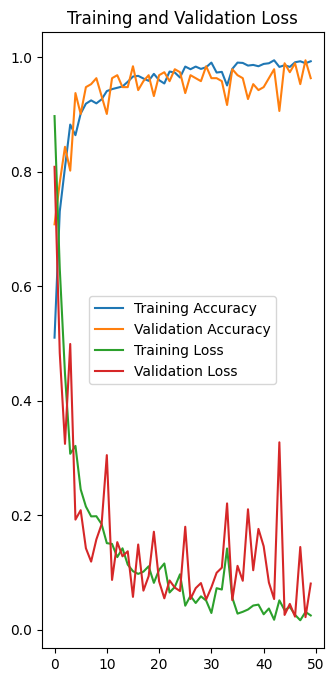

In [44]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='center')
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,1)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='center')
plt.title("Training and Validation Loss")
plt.show()

In [52]:
import numpy as np
np.argmax([9.9999487e-01, 5.1557831e-06, 2.3572479e-19])

0

first image to predict
first image's actual label: Potato___Early_blight
1/1 [==============================] - 0s 32ms/step
predicted label: Potato___Early_blight


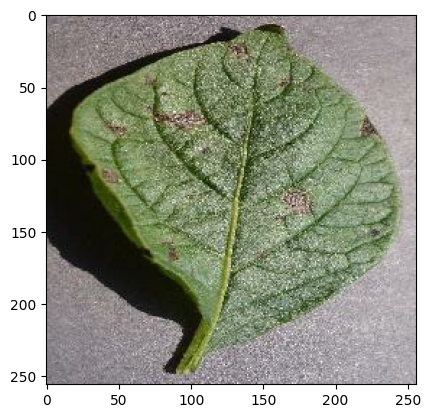

In [55]:
for images_batch, labels_batch in test_ds.take(1):
  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print("first image to predict")
  plt.imshow(first_image)
  print("first image's actual label:",class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [63]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0) #creating a batch

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)

  return predicted_class, confidence

1/1 [==============================] - 0s 22ms/step


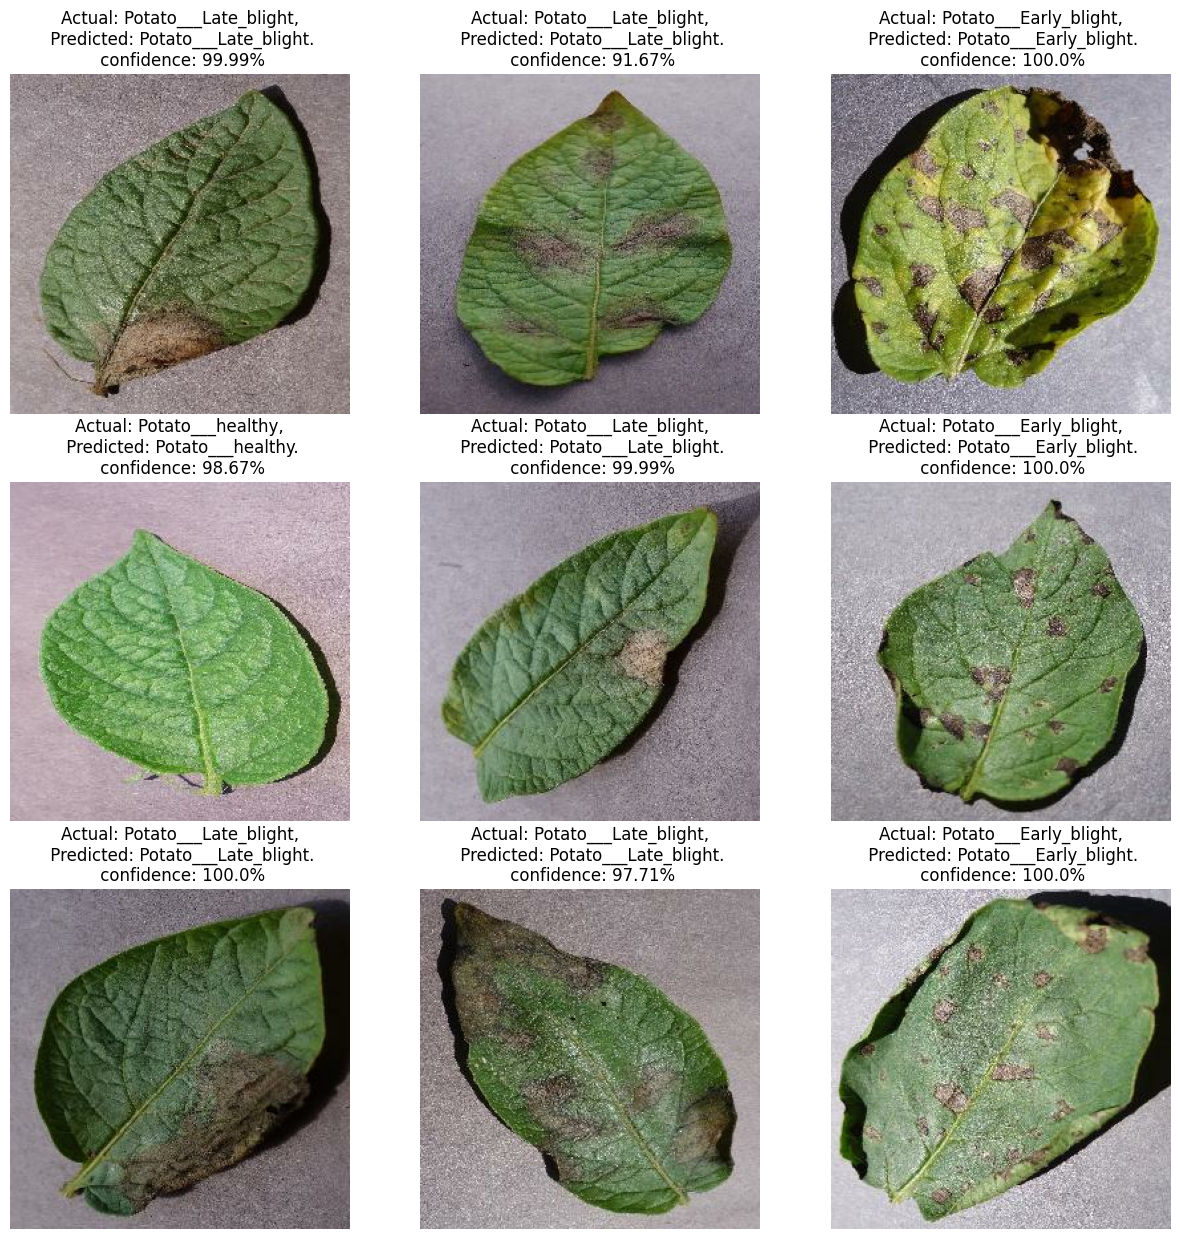

In [67]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)

    plt.imshow(images[i].numpy().astype('uint8'))
    predicted_class, confidence = predict(model, images[i].numpy)
    actual_class = class_names[labels[i]]
    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n confidence: {confidence}%")
    plt.axis("off")

In [ ]:
model_version = 1